# Implementazione di un riconoscitore vocale di emozioni per rilevare rabbia/stress

### Introduzione

Con questo progetto vorrei tracciare i passi fondamentali per l'implementazione di un riconoscitore delle emozioni, concentrandomi sul rilevamento del sentimento di rabbia/stress attraverso l’utilizzo di un metodo predittivo.

### Perché comprendere le emozioni dell’interlocutore?

Il riconoscimento vocale delle emozioni rappresenta un'area di grande importanza nel mondo dell'interazione uomo-macchina: infatti comprendere le emozioni dell’interlocutore può migliorare l'esperienza utente in varie applicazioni, come ad esempio nella sfera degli assistenti virtuali, del servizio clienti, o nel monitoraggio dello stato mentale di un individuo. Potrebbe persino essere usato per un potenziale “upgrade” di una macchina della verità: la macchina della verità, grazie a svariate decine di sensori, registra alcuni parametri fisiologici di una persona (la pressione sanguigna, battito cardiaco, ritmo della respirazione) mentre questa stessa persona risponde ad una lunga serie di domande. Le eventuali alterazioni di questi parametri vengono registrati dalla macchina e analizzati da un esperto, che determinerà se l'interrogato stia mentendo o meno.

L’analisi della voce dell’interrogato potrebbe dare qualche indizio in più: tendenzialmente, il linguaggio vocale esprime il fatto che una persona stia mentendo attraverso un tono alto della voce, una voce tremolante, e risposte secche e veloci, aspetti tipici di una persona stressata e/o arrabbiata.

Per poter creare un riconoscitore delle emozioni è fondamentale analizzare vari parametri vocali dell’interlocutore, tra cui intensità, frequenza.. Queste caratteristiche verrano inserite in un modello di Machine Learning per classificare le emozioni.

### Perché la Regressione Logistica?

La regressione logistica è una scelta adatta per i problemi di classificazione binaria, dove l'obiettivo è prevedere uno tra due possibili risultati. In questo contesto, la regressione logistica ci aiuterà a determinare se chi sta parlando è arrabbiato o meno sulla base di caratteristiche estratte dal suo discorso/dalla sua voce.

### 1. Data Loading and Preprocessing

Ho deciso di unire 3 dataset recuperati di Kaggle perfetti per il mio scopo:

1) RAVDESS: dataset di 1440 tracce audio di 24 attori (12 maschi, 12 femmine) che pronunciano due frasi con diverse emozioni, ogni emozione prima con intensità "normale" e poi "forte".
Ogni file è caratterizzato da un nome codificato come stringa di 7 coppie numeriche per definire le caratteristiche dell'audio:

Modalità (01 = AV, 02 = video, 03 = audio)

Canale vocale (01 = voce parlata, 02 = canzone)

Emozione (01 = neutralità, 02 = calma, 03 = felicità, 04 = tristezza, 05 = rabbia, 06 = paura, 07 = disgusto, 08 = sorpresa)

Intensità (01 = normale, 02 = forte)

Frase (01 = Kids are talking by the door, 02 = Dogs are sitting by the door)

Ripetizione (01 = prima ripetizione, 02 = seconda ripetizione)

Attore (range: [01-24], in cui i numeri dispari indicano "attore maschio" e i numeri pari "attrice femmina")

2) CREMA-D: dataset di 7442 tracce audio di 91 attori (48 maschi, 43 femmine) che pronunciano 12 frasi con diverse emozioni a 4 livelli di intensità (bassa, media, alta, non specificata).
Ogni file è caratterizzato da un nome codificato in:

Attore (numero a 4 cifre)

Frase (IEO = It's eleven o'clock, TIE = That is exactly what happened, IOM = I'm on my way to the meeting, IWW = I wonder what this is about, TAI = The airplane is almost full, MTI = Maybe tomorrow it will be cold, IWL = I would like a new alarm clock, ITH = I think I have a doctor's appointment, DFA = Don't forget a jacket, ITS = I think I've seen this before, TSI = The surface is slick, WSI = We'll stop in a couple of minutes)

Emozione (ANG = rabbia, DIS = disgusto, FEA = paura, HAP = felicità, NEU = neutralità, SAD = tristezza)

Intensità (LO = bassa, MD = media, HI = alta, XX = non specificata)

3) SAVEE: dataset di 480 tracce audio di 4 attori che pronunciano 15 frasi per ogni emozione. Ogni file è caratterizzato da un nome codificato in:

Attore (DC, JE, JK, KL)


Emozione ('a' = rabbia 'd' = disgusto 'f' = paura 'h' = felicità 'n' = neutralità 'sa' = tristezza 'su' = sorpresa)


Frase (range: [01-15])

In [38]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import warnings
import seaborn as sns
import scipy.signal as signal
import sklearn.metrics as metrics

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import Audio
warnings.filterwarnings('ignore')

In [39]:
ravdess = "RAVDESS/audio_speech_actors_01-24"
crema = "CREMA"
savee = "SAVEE"

In [40]:
currdir = os.getcwd()
ravdess = os.path.join(currdir, ravdess)
crema = os.path.join(currdir, crema)
savee = os.path.join(currdir, savee)

### RAVDESS

In [41]:
ravdess_directory = os.listdir(ravdess)
emotion = []
path = []
for actor_folder in ravdess_directory:
    audio_files = os.listdir(ravdess + "/" + actor_folder)
    for file in audio_files:
        part = file.split('.')[0]
        part = part.split('-')
        emotion.append(int(part[2]))
        path.append(ravdess + "/" + actor_folder + '/' + file)

emotion_df = pd.DataFrame(emotion, columns=['Emozioni'])
path_df = pd.DataFrame(path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

ravdess_df.Emozioni.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print("RAVDESS:")
ravdess_df.head()

RAVDESS:


Emozioni                                               Path
0    angry  /Users/sararosselli/Documents/TESI/RAVDESS/aud...
1     fear  /Users/sararosselli/Documents/TESI/RAVDESS/aud...
2     fear  /Users/sararosselli/Documents/TESI/RAVDESS/aud...
3    angry  /Users/sararosselli/Documents/TESI/RAVDESS/aud...
4  disgust  /Users/sararosselli/Documents/TESI/RAVDESS/aud...

### CREMA-D

In [42]:
crema_directory = os.listdir(crema)

emotion = []
path = []

for file in crema_directory:
    path.append(crema + "\\" + file)
    part=file.split('_')
    if part[2] == 'SAD':
        emotion.append('sad')
    elif part[2] == 'ANG':
        emotion.append('angry')
    elif part[2] == 'DIS':
        emotion.append('disgust')
    elif part[2] == 'FEA':
        emotion.append('fear')
    elif part[2] == 'HAP':
        emotion.append('happy')
    elif part[2] == 'NEU':
        emotion.append('neutral')
    else:
        emotion.append('Unknown')
emotion_df = pd.DataFrame(emotion, columns=['Emozioni'])
path_df = pd.DataFrame(path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

Emozioni                                               Path
0    angry  /Users/sararosselli/Documents/TESI/CREMA\1022_...
1    angry  /Users/sararosselli/Documents/TESI/CREMA\1037_...
2  neutral  /Users/sararosselli/Documents/TESI/CREMA\1060_...
3  neutral  /Users/sararosselli/Documents/TESI/CREMA\1075_...
4  disgust  /Users/sararosselli/Documents/TESI/CREMA\1073_...

### SAVEE

In [43]:
savee_directory = os.listdir(savee)

file_emotion = []
path = []

for file in savee_directory:
    path.append(savee + "\\" + file)
    part = file.split('_')[1]
    emotion = part[:-6]
    if emotion == 'a':
        file_emotion.append('angry')
    elif emotion == 'd':
        file_emotion.append('disgust')
    elif emotion == 'f':
        file_emotion.append('fear')
    elif emotion == 'h':
        file_emotion.append('happy')
    elif emotion == 'n':
        file_emotion.append('neutral')
    elif emotion == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emozioni'])
print(emotion_df)

path_df = pd.DataFrame(path, columns=['Path'])
print(path_df)
savee_df = pd.concat([emotion_df, path_df], axis=1)
savee_df.head()

     Emozioni
0         sad
1         sad
2     neutral
3    surprise
4     neutral
..        ...
475     angry
476     angry
477   neutral
478  surprise
479  surprise

[480 rows x 1 columns]
                                                  Path
0    /Users/sararosselli/Documents/TESI/SAVEE\JK_sa...
1    /Users/sararosselli/Documents/TESI/SAVEE\JK_sa...
2    /Users/sararosselli/Documents/TESI/SAVEE\DC_n1...
3    /Users/sararosselli/Documents/TESI/SAVEE\DC_su...
4    /Users/sararosselli/Documents/TESI/SAVEE\DC_n0...
..                                                 ...
475  /Users/sararosselli/Documents/TESI/SAVEE\JE_a0...
476  /Users/sararosselli/Documents/TESI/SAVEE\JE_a1...
477  /Users/sararosselli/Documents/TESI/SAVEE\DC_n2...
478  /Users/sararosselli/Documents/TESI/SAVEE\DC_su...
479  /Users/sararosselli/Documents/TESI/SAVEE\DC_su...

[480 rows x 1 columns]


Emozioni                                               Path
0       sad  /Users/sararosselli/Documents/TESI/SAVEE\JK_sa...
1       sad  /Users/sararosselli/Documents/TESI/SAVEE\JK_sa...
2   neutral  /Users/sararosselli/Documents/TESI/SAVEE\DC_n1...
3  surprise  /Users/sararosselli/Documents/TESI/SAVEE\DC_su...
4   neutral  /Users/sararosselli/Documents/TESI/SAVEE\DC_n0...

Ora che ho caricato i dataset posso unirli insieme in uno unico e creare un file csv

In [44]:
emotions_df = pd.concat([ravdess_df, crema_df, savee_df], axis = 0)
emotions_df.to_csv("emotions_df.csv",index=False)
emotions_df.head()

Emozioni                                               Path
0    angry  /Users/sararosselli/Documents/TESI/RAVDESS/aud...
1     fear  /Users/sararosselli/Documents/TESI/RAVDESS/aud...
2     fear  /Users/sararosselli/Documents/TESI/RAVDESS/aud...
3    angry  /Users/sararosselli/Documents/TESI/RAVDESS/aud...
4  disgust  /Users/sararosselli/Documents/TESI/RAVDESS/aud...

In [45]:
emotions_df = pd.read_csv("emotions_df.csv")
print(type(emotions_df.Emozioni[1]))
emotions_df.Emozioni

<class 'str'>


0          angry
1           fear
2           fear
3          angry
4        disgust
          ...   
9357       angry
9358       angry
9359     neutral
9360    surprise
9361    surprise
Name: Emozioni, Length: 9362, dtype: object

In [46]:
emotions_df.info()
emotions_df.Emozioni.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9362 entries, 0 to 9361
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emozioni  9362 non-null   object
 1   Path      9362 non-null   object
dtypes: object(2)
memory usage: 146.4+ KB


Emozioni
angry       1523
fear        1523
disgust     1523
sad         1523
happy       1523
neutral     1303
surprise     252
calm         192
Name: count, dtype: int64

Abbiamo ottenuto un dataset di 9362 tuple che non contengono valori nulli.

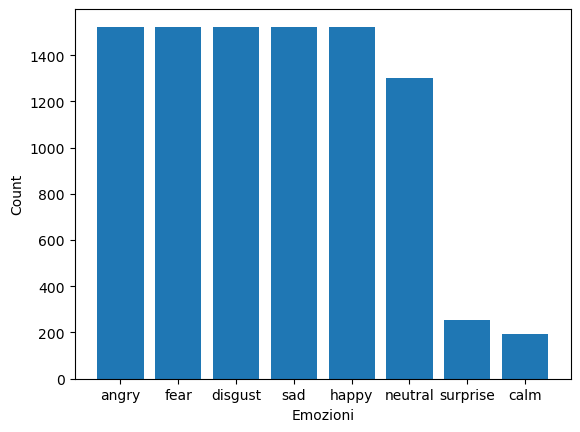

In [47]:
counts = emotions_df['Emozioni'].value_counts()

plt.bar(counts.index, counts.values)

plt.xlabel('Emozioni')
plt.ylabel('Count')

plt.show()

Per il nostro scopo vogliamo concentrarci sulla categoria "angry", che grazie alla concatenazione dei 3 dataset vediamo essere diventata abbastanza "corposa" da poter permettere di effettuare delle analisi.

Prima di procedere con le analisi applico un filtro passa banda per attenuare il rumore degli audio 

In [48]:
#def butter_bandpass(lowcut, highcut, fs, order=5):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    #b, a = butter(order, [low, high], btype='band')
    #return b, a

#def bandpass_filter(data, fs, lowcut, highcut, order=5):
    #b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #y = lfilter(b, a, data)
    #return y

In [49]:
#filtered_data = []

#for path in emotions_df['Path']:
    #path = path.replace("\\", "/")
    #data, sr = librosa.load(path, sr=None)
    #filtered_audio = bandpass_filter(data, fs, 110, 1500)
    #filtered_data.append(filtered_audio)

#emotions_df['Filtered_Data'] = filtered_data

### 2. Data Visualization

Implemento una funzione per visualizzare un waveplot per individuare l'ampiezza del segnale audio nel dominio del tempo e osservarne le variazioni (così da poter notare caratteristiche quali picchi o pause), e una funzione per creare uno spettrogramma per visualizzare la distribuzione delle frequenze nel tempo 

In [50]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot per audio con emozione: {} '.format(emotion), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    stft_matrix = librosa.stft(data)
    stft_matrix_db = librosa.amplitude_to_db(abs(stft_matrix))
    plt.figure(figsize=(12, 3))
    plt.title('Spettrogramma per audio con emozione: {} (linear scale)'.format(emotion), size=15)
    librosa.display.specshow(stft_matrix_db, sr=sr, x_axis='s', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.figure(figsize=(12, 3))
    plt.title('Spettrogramma per audio con emozione: {} (log scale)'.format(emotion), size=15)
    librosa.display.specshow(stft_matrix_db, sr=sr, x_axis='s', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

Visualizziamo il waveplot e i relativi spettrogrammi dell'audio del nostro dataset corrispondente all'emozione "angry" con indice 1:

/Users/sararosselli/Documents/TESI/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-05-02-01-01-16.wav


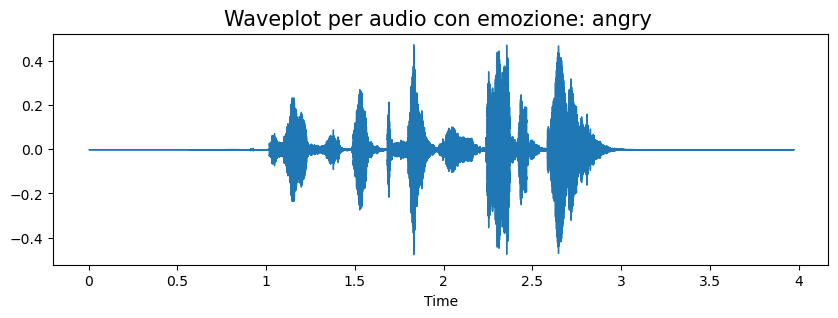

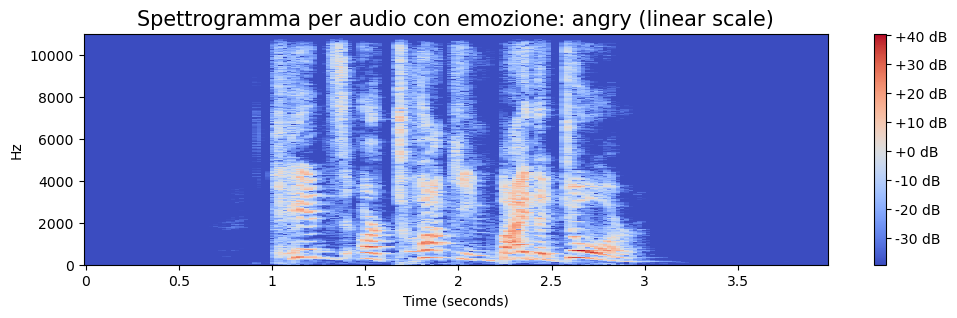

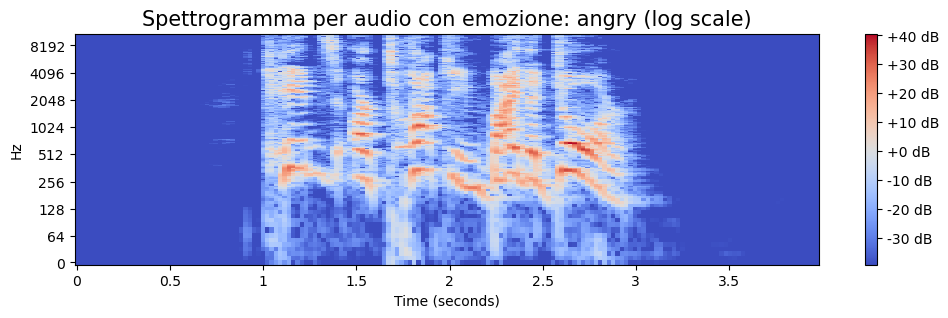

In [51]:
emotion='angry'
path = np.array(emotions_df.Path[emotions_df.Emozioni==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Stessa attrice e stessa frase con emozione "calm":

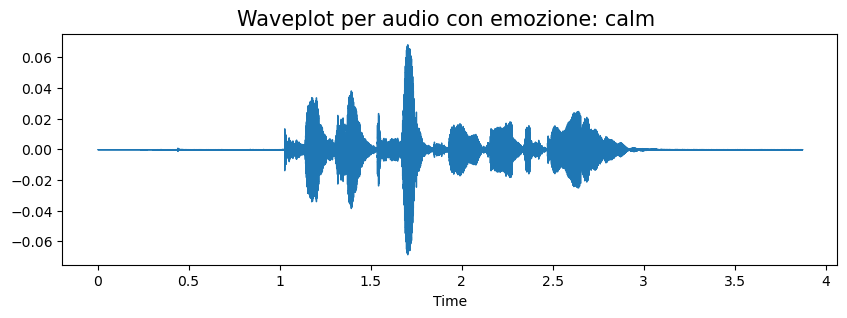

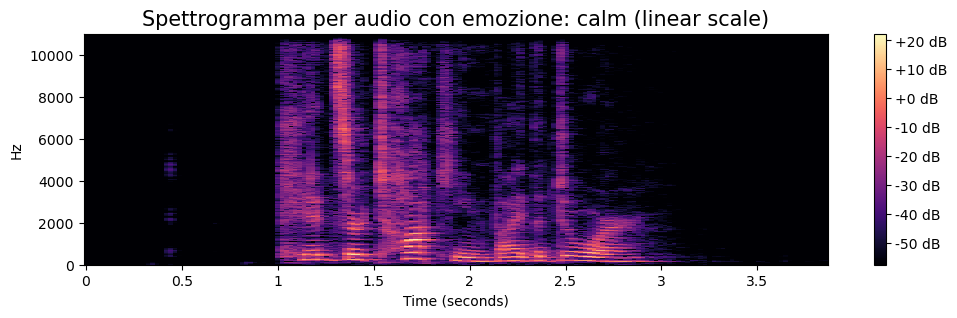

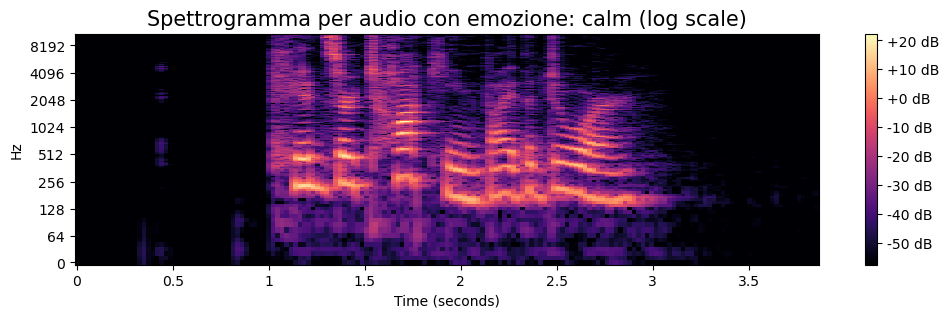

In [52]:
emotion='calm'
path = '/Users/sararosselli/Documents/TESI/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-02-02-01-01-16.wav'
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Ora con indice 100

/Users/sararosselli/Documents/TESI/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-02-02-01-02-12.wav


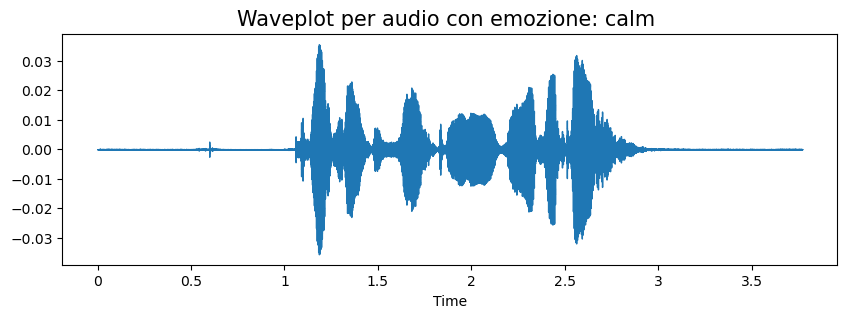

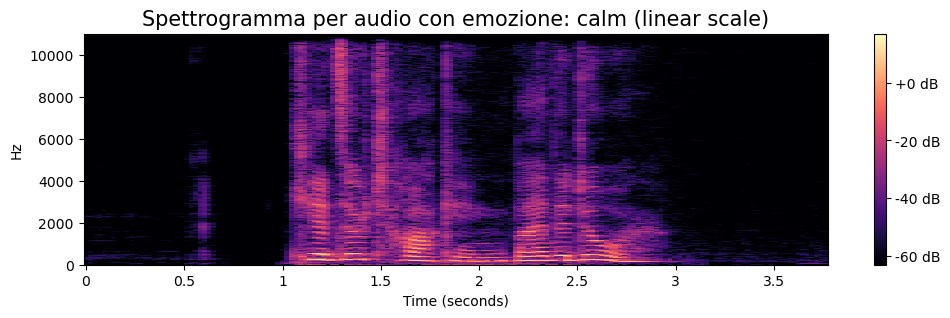

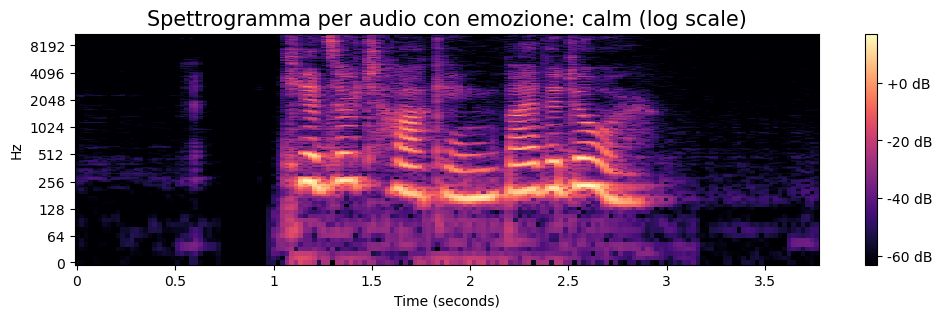

In [53]:
path = np.array(emotions_df.Path[emotions_df.Emozioni==emotion])[100]
print(path)
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Con indice 150

/Users/sararosselli/Documents/TESI/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-02-01-01-01-13.wav


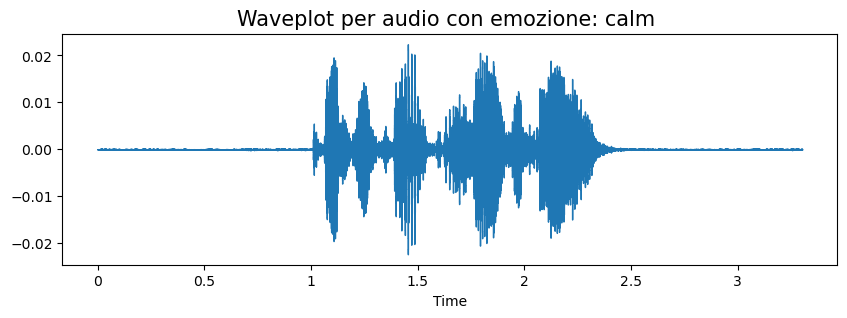

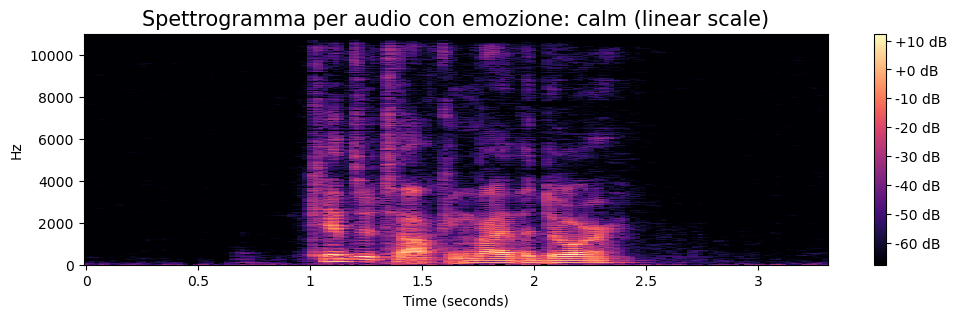

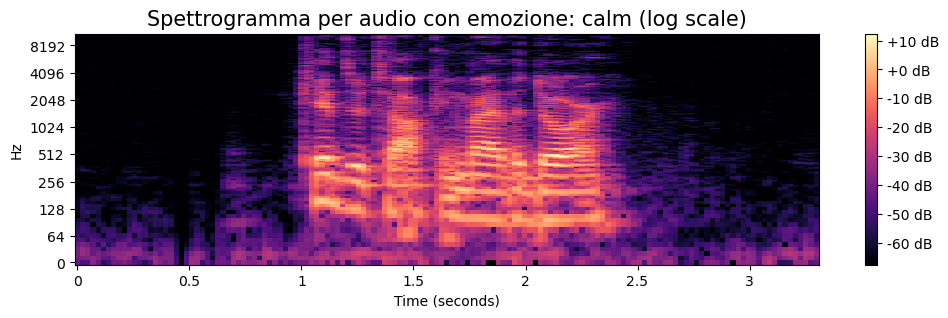

In [54]:
path = np.array(emotions_df.Path[emotions_df.Emozioni==emotion])[150]
print(path)
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Con indice 191

/Users/sararosselli/Documents/TESI/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-02-01-02-01-08.wav


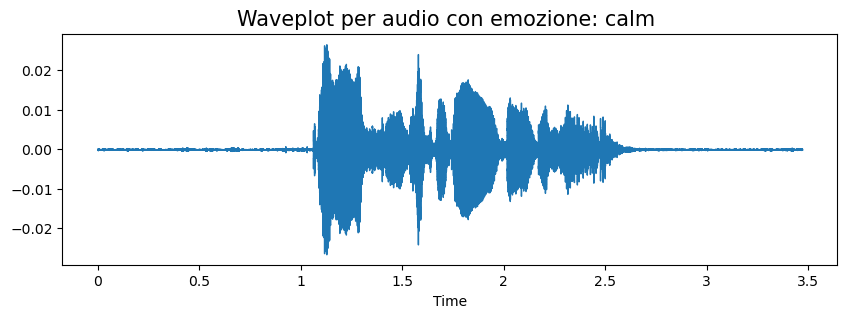

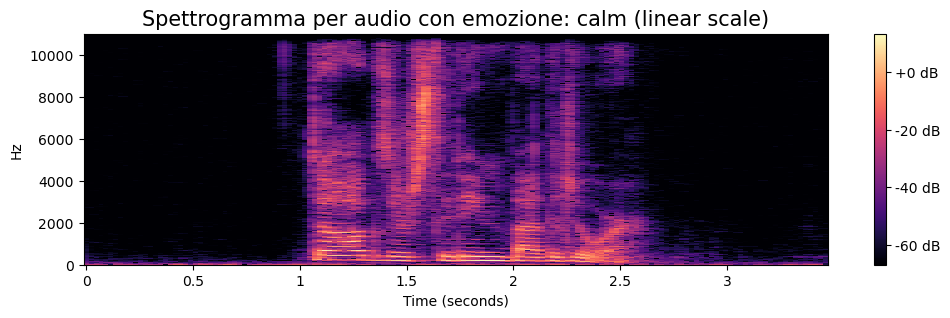

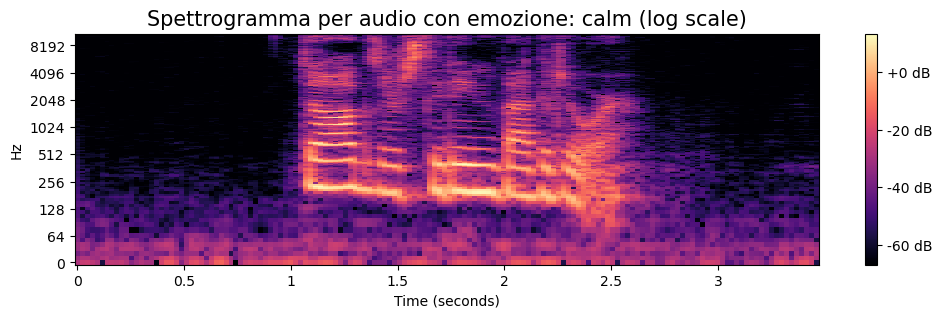

In [55]:
path = np.array(emotions_df.Path[emotions_df.Emozioni==emotion])[191]
print(path)
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

### 3. Features extraction

Sappiamo che ad ogni segnale audio digitale sono associati due parametri fondamentali: la "sample rate" (o "sample frequency") e la "sample data". Queste misure vengono utilizzate per convertire un segnale analogico (a tempo continuo e a valori continui) in un segnale digitale (a tempo discreto e a valori discreti)

Sample rate: rappresenta la frequenza di campionamento, cioè il numero di campioni di un segnale audio presi per secondo (misurato in Hertz). Ci dà quindi l'informazione sull'intervallo di tempo in cui la macchina misurerà il valore del segnale in modo da discretizzarlo. Ovviamente può sarà frequente il campionamento più la quantizzazione del segnale analogico sarà "precisa".

Sample data: rappresenta le misurazioni individuali dell'ampiezza del segnale audio in ciascun punto nel tempo, prese alla frequenza di campionamento specificata. E' associata alla "bit depth", che indica quanti bit sono utilizzati per memorizzare ciascun campione.

L'energia del segnale audio fornisce una misura dell'intensità o della potenza del segnale in un frame specifico, ed è calcolata come la somma dei quadrati dei valori del segnale, normalizzata per la lunghezza del frame.

Con la frequenza di campionamento, i dei dati del campione e l'energia, si possono eseguire diverse trasformazioni su di esso per estrarre features utili al nostro scopo:

1. Zero Cross Rate
2. MFCC
3. Mel Spectrogram Frequency
4. Chroma Vector
5. Chroma Deviation


#### Zero Cross Rate
Questo parametro quantifica il numero di volte che il segnale audio attraversa il livello zero (cioè cambia segno) in un dato intervallo di tempo; i suoni armonici hanno generalmente un basso tasso di attraversamento dello zero, mentre rumori e suoni impulsivi tendono ad avere un alto tasso di attraversamento dello zero.

#### MFCC: Mel Frequency Cepstral Coefficient
E' una rappresentazione del segnale tramite coefficienti che catturano le caratteristiche spettrali di un segnale audio in modo da modellare la percezione umana del suono, tenendo conto di come l'orecchio umano percepisce le diverse frequenze.

Utilizza la scala Mel, una scala di frequenze percettive progettata per approssimare la risposta della coclea umana (la parte dell'orecchio che si occupa del senso dell'udito) alle frequenze percepite. Infatti la percezione umana delle frequenze non è lineare: siamo più sensibili ai cambiamenti nelle frequenze più basse rispetto a quelle più alte.

I coefficienti cepstrali rappresentano lo spettro di potenza di un segnale audio, trasformato in modo da separare le componenti della fonte e del filtro del segnale audio.

Processo di Calcolo:
1. Si applica un filtro per aumentare l'energia delle alte frequenze.
2. Il segnale audio viene suddiviso in brevi segmenti di tempo (finestre).
3. Viene calcolata la trasformata di Fourier di ogni finestra per ottenere lo spettro di frequenza.
4. Si applica un banco di filtri in scala Mel allo spettro di potenza.
5. Si prende il logaritmo dell'energy in ciascun filtro Mel.
6. Si applica la trasformata discreta del coseno (DCT) (simile alla Trasformata di Fourier (DFT), ma utilizza solo coseni invece di sinusoidi complesse) ai logaritmi per ottenere i coefficienti cepstrali.

#### Mel Spectrogram Frequency
E' uno spettrogramma tradizionale, ma con la frequenza rappresentata sulla scala Mel. Come per un qualsiasi spettrogramma viene calcolato dividendo il segnale audio in brevi segmenti di tempo (finestre) e calcolando la trasformata di Fourier per ciascuna finestra, ma in seguito vengono applicati una serie di filtri in scala Mel ad ogni finestra, in modo da ottenere una risoluzione più fine delle frequenze più basse e una risoluzione più grossolana delle frequenze più alte, in linea con la percezione umana.

#### Chroma Vector e Chroma Deviation
Il Chroma Vector è una rappresentazione delle proprietà armoniche e melodiche di un segnale audio. Questi vettori catturano le informazioni relative alle 12 classi di note della scala cromatica occidentale (do, do#, re, re#, mi, fa, fa#, sol, sol#, la, la#, si). La Chroma Deviation è una misura statistica utilizzata per valutare la variazione o la stabilità dei Chroma Vectors nel tempo.


In questo progetto ho deciso di estrapolare la caratteristica dei MFCC, che mi sembra la più adatta per il mio scopo.

In [56]:
def extract_mfcc(data, sr, n_mfcc=20): # n_mfcc = numero di coefficienti da estrarre
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc), axis=1)
    return mfccs

In [57]:
extract_mfcc(data, sampling_rate)

array([-7.0856342e+02,  6.6587616e+01,  2.1861507e+01,  2.1603155e+01,
        9.8483887e+00,  7.6265163e+00,  5.3627205e+00, -7.0741682e+00,
        4.7613555e-01,  4.6836343e-03,  5.4791158e-01, -4.3964748e+00,
        2.1706529e+00, -3.1192455e-01, -1.9726174e+00, -8.4164268e-01,
       -9.7193092e-01,  3.7418869e+00,  1.3187590e+00,  2.9725287e+00],
      dtype=float32)

Questi sono i coefficienti estratti dai miei dati

In [58]:
mfccs = emotions_df['Path'].apply(lambda x: extract_mfcc(librosa.load(x.replace("\\", "/"))[0], sampling_rate))
mfccs

0       [-542.26056, 33.782993, -3.8036203, 3.0919883,...
1       [-550.81915, 37.232445, -5.9668612, 4.7323546,...
2       [-390.47702, 18.890253, -27.031868, 0.87237453...
3       [-440.9078, 33.383163, -8.692477, 4.528371, -1...
4       [-625.4138, 50.351124, -0.10346615, 9.324964, ...
                              ...                        
9357    [-242.53232, 105.94387, 1.0212487, 41.490063, ...
9358    [-307.62204, 107.92219, 13.13552, 44.44106, 17...
9359    [-449.69916, 145.44629, 43.794575, 27.957186, ...
9360    [-299.08636, 115.94267, 14.433521, 21.851297, ...
9361    [-305.17532, 110.84941, 12.119499, 16.853937, ...
Name: Path, Length: 9362, dtype: object

Creo un dataframe con i valori dei coefficienti corrispondenti ad ogni tupla nel mio dataset e lo aggiungo al dataset originale

In [59]:
mfcc_df = pd.DataFrame(mfccs.tolist(), columns=[f'MFCC_{i}' for i in range(20)])
emotions_df = pd.concat([emotions_df, mfcc_df], axis=1)

In [60]:
emotions_df.head()

Emozioni                                               Path      MFCC_0  \
0    angry  /Users/sararosselli/Documents/TESI/RAVDESS/aud... -542.260559   
1     fear  /Users/sararosselli/Documents/TESI/RAVDESS/aud... -550.819153   
2     fear  /Users/sararosselli/Documents/TESI/RAVDESS/aud... -390.477020   
3    angry  /Users/sararosselli/Documents/TESI/RAVDESS/aud... -440.907806   
4  disgust  /Users/sararosselli/Documents/TESI/RAVDESS/aud... -625.413818   

      MFCC_1     MFCC_2    MFCC_3     MFCC_4     MFCC_5     MFCC_6     MFCC_7  \
0  33.782993  -3.803620  3.091988  -9.681703  -6.023736  -8.644806 -11.424563   
1  37.232445  -5.966861  4.732355  -2.008577  -9.404687 -14.451254 -14.265598   
2  18.890253 -27.031868  0.872375  -9.466906 -16.579592 -13.888435 -13.248320   
3  33.383163  -8.692477  4.528371 -10.455300 -11.298501  -4.232059 -10.755424   
4  50.351124  -0.103466  9.324964  -5.052660  -1.202212  -9.441996 -10.114931   

   ...    MFCC_10   MFCC_11   MFCC_12   MFCC_13   MFCC_14   MFCC_15   MFCC_16  \
0  ...  -7.245757 -5.946874 -3.147820 -5.415155 -6.079906 -5.448544 -2.283980   
1  ... -12.590665 -7.839362  1.532468 -6.720428 -6.038458 -4.286009 -5.639621   
2  ... -14.074067 -2.609262  9.437303  1.039263  4.889710  5.685410  8.467120   
3  ...  -9.219634 -3.287563 -0.883639 -6.102853 -4.041292 -6.511432 -4.963793   
4  ...  -6.393939 -5.310205  1.681183 -4.568727 -5.344860 -2.071920 -5.418761   

     MFCC_17   MFCC_18   MFCC_19  
0  -6.972795 -5.977275 -2.386893  
1  -3.116365 -4.289154 -4.300075  
2  10.464809  4.979053  3.413332  
3  -2.459838 -2.488266  1.051183  
4  -3.250186 -4.836430 -3.517403  

[5 rows x 22 columns]

### 4. Data Augmentation

Considerato il rapporto tra il numero di istanze la cui categoria è "angry" e tutte le altre, possiamo effettuare un'operazione di Data Augmentation perturbando leggeremente alcune tuple del dataset con emozione = "angry", così da creare artificialmente altre istanze appartenenti a questa categoria e diminuire la discrepanza nel numero di tuple, che potrebbe influenzare negativamente il processo di predizione; inoltre quest'operazione aiuta a rendere il nostro modello più "generalizzante" e robusto a variazioni nei dati.

Creo una funzione che aggiunge un leggero rumore ad ogni audio e una funzione che aumenta il pitch della voce

In [61]:
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [62]:
def pitch_shift(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

Aggiungo rumore all'audio precedente e ne aumento il pitch per verificare il corretto funzionamento delle mie due funzioni

<Figure size 1400x400 with 0 Axes>

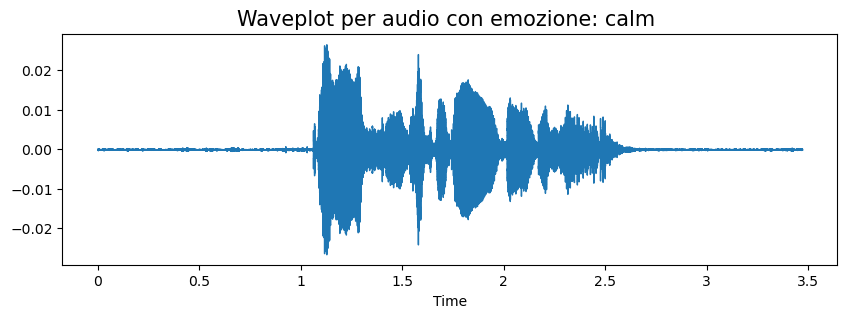

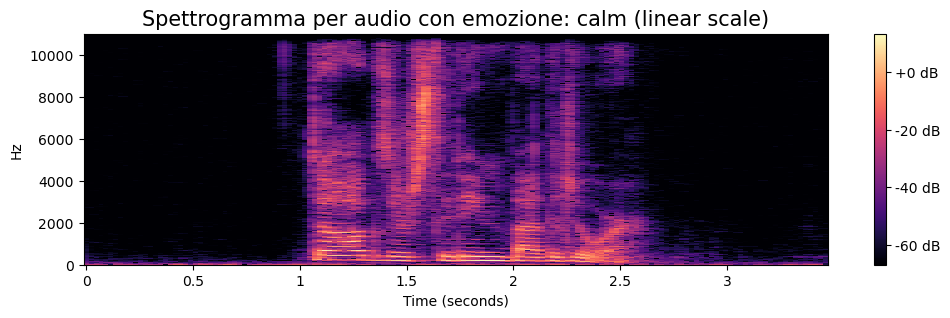

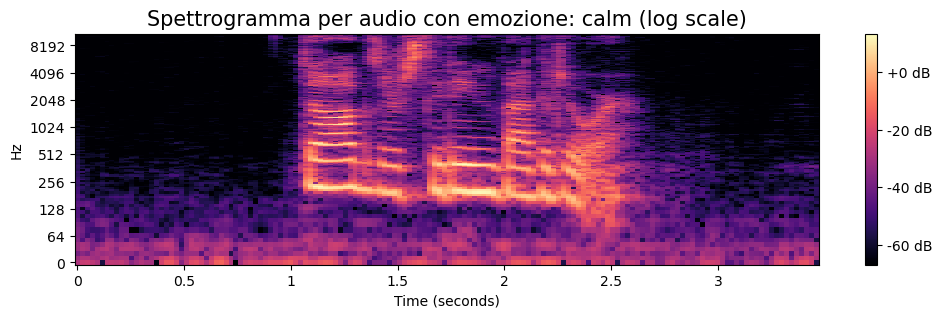

In [63]:
x = add_noise(data)
plt.figure(figsize=(14,4))
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(x, rate=sampling_rate)

<Figure size 1400x400 with 0 Axes>

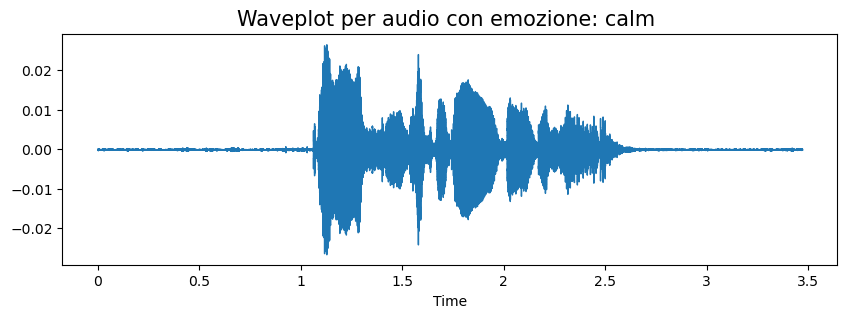

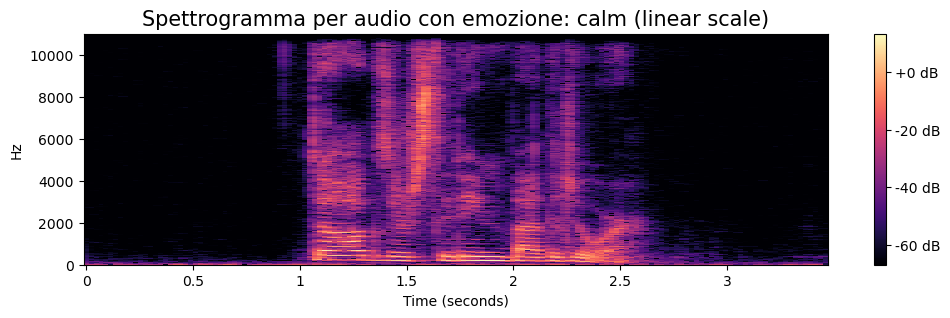

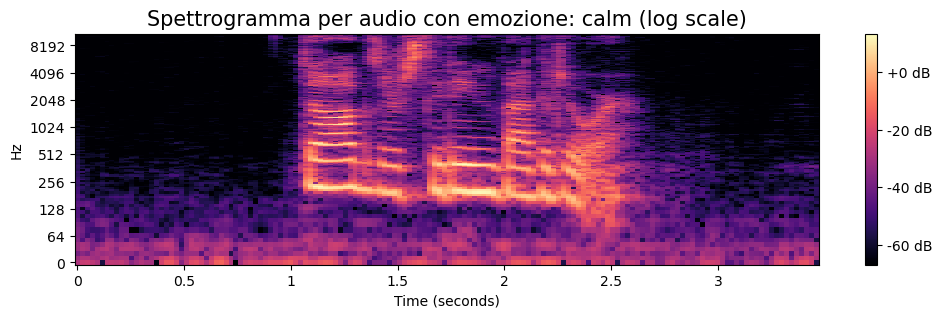

In [64]:
pitch_shift(data, sampling_rate, 2)
plt.figure(figsize=(14,4))
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(pitch_shift(data, sampling_rate, 4), rate=sampling_rate)

A questo punto creo le nuove istanze applicando le due funzioni alle tuple la cui emozione associata è "angry".

Inserisco poi i dati in un dataframe e associo loro i corrispettivi MFCC.

Concateno poi in dataframe ottenuto con quello originale.

In [65]:
# filtro i dati per ottenere solo quelli con emozione 'angry'
angry_df = emotions_df[emotions_df['Emozioni'] == 'angry']

emotion = 'angry'

augmented_data = []
augmented_labels = []

# eseguo l'augmentation solo sui dati con emozione 'angry'
for index, row in angry_df.iterrows():
    path = row['Path'].replace("\\", "/")
    emotion = row['Emozioni']
    
    data, sr = librosa.load(path, duration=3, offset=0.5)
    
    # dati originali
    augmented_data.append(extract_mfcc(data, sr))
    augmented_labels.append(emotion)
    
    # dati con rumore
    data_with_noise = add_noise(data)
    augmented_data.append(extract_mfcc(data_with_noise, sr))
    augmented_labels.append(emotion)
    
    # dati con pitch shift
    data_pitch_shifted = pitch_shift(data, sr, pitch_factor=2)
    augmented_data.append(extract_mfcc(data_pitch_shifted, sr))
    augmented_labels.append(emotion)

# converto i dati in dataframe
augmented_df = pd.DataFrame(augmented_data, columns=[f'MFCC_{i}' for i in range(20)])  # 20 MFCC features
augmented_df['Emozioni'] = augmented_labels

# aggiungo i nuovi dati al dataframe originale
augmented_emotions_df = pd.concat([emotions_df, augmented_df], ignore_index=True)

augmented_emotions_df['Binary_Emozioni'] = augmented_emotions_df['Emozioni'].apply(lambda x: 1 if x == 'angry' else 0)

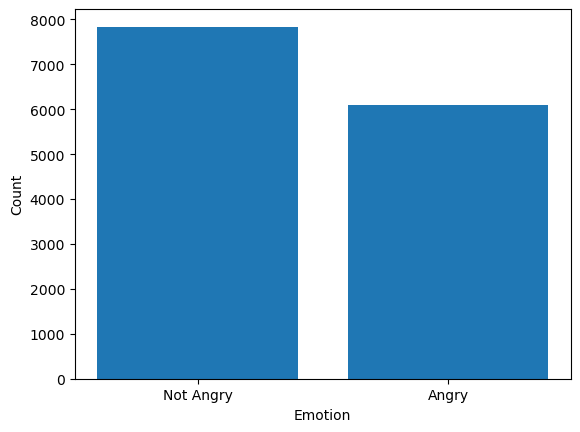

In [66]:
counts = augmented_emotions_df['Binary_Emozioni'].value_counts()

plt.bar(['Not Angry', 'Angry'], counts.values)

plt.xlabel('Emotion')
plt.ylabel('Count')

plt.show()

In [67]:
augmented_emotions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13931 entries, 0 to 13930
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Emozioni         13931 non-null  object 
 1   Path             9362 non-null   object 
 2   MFCC_0           13931 non-null  float32
 3   MFCC_1           13931 non-null  float32
 4   MFCC_2           13931 non-null  float32
 5   MFCC_3           13931 non-null  float32
 6   MFCC_4           13931 non-null  float32
 7   MFCC_5           13931 non-null  float32
 8   MFCC_6           13931 non-null  float32
 9   MFCC_7           13931 non-null  float32
 10  MFCC_8           13931 non-null  float32
 11  MFCC_9           13931 non-null  float32
 12  MFCC_10          13931 non-null  float32
 13  MFCC_11          13931 non-null  float32
 14  MFCC_12          13931 non-null  float32
 15  MFCC_13          13931 non-null  float32
 16  MFCC_14          13931 non-null  float32
 17  MFCC_15     

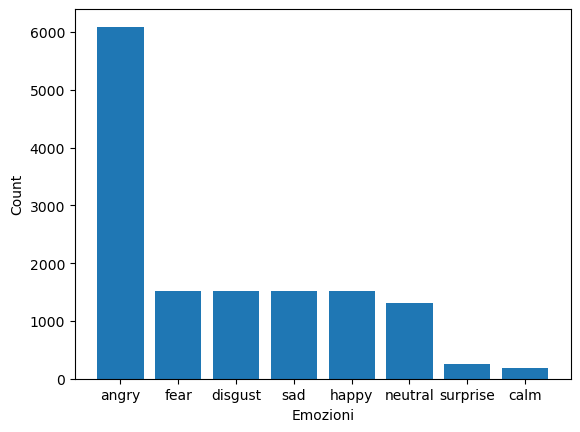

In [68]:
counts = augmented_emotions_df['Emozioni'].value_counts()

plt.bar(counts.index, counts.values)

plt.xlabel('Emozioni')
plt.ylabel('Count')

plt.show()

### 5. Model training and evaluation

A questo punto possiamo implementare un modello di Regressione Lineare come metodo predittivo di classificazione.

Precedentemente ho binarizzato i valori delle emozioni in:

- 1 se l'emozione corrispondente all'instanza è = "angry"

- 0 altrimenti

Abbiamo che:

- X: estrae le caratteristiche MFCC dal dataframe "augmented_emotions_df", ottenendo una matrice di caratteristiche, in cui ogni colonna rappresenta un coefficiente MFCC

- y_binary: estrae le etichette (0 e 1) dal dataframe

- viene diviso il dataset in training-set e test-set

- viene istanziato un oggetto della classe LogisticRegression

- il modello viene allenato

- viene utilizzato il modello imparato per effettuare predizioni sul test-set

- verifichiamo l'efficienza del nostro modello:

    1. calcolo l'indice di accuratezza

    2. calcolo 3 tipi di errori: MAE, MSE, RMSE

    3. confronto questi modelli con un modello nullo in cui predico la media della variabile "tirando a indovinare" più e più volte il risultato atteso

    4. controllo il report di classificazione, dettato da: precisione (la proporzione di veri positivi tra tutti i campioni che sono stati predetti come positivi (veri positivi + falsi positivi)), richiamo (la proporzione di veri positivi tra tutti i campioni che appartengono realmente a quella classe (veri positivi + falsi negativi)), F1-score (media armonica tra precisione e richiamo), supporto (quanti campioni della classe "angry" sono presenti nel test-set)

    5. visualizziamo la matrice di confusione


Accuratezza del mio modello: 0.8604233943308217
MAE: 0.140
MSE: 0.140
RMSE: 0.374

Modello nullo:
MAE: 0.492
MSE: 0.246
RMSE: 0.496

Report di cassificazione:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1568
           1       0.86      0.81      0.84      1219

    accuracy                           0.86      2787
   macro avg       0.86      0.86      0.86      2787
weighted avg       0.86      0.86      0.86      2787



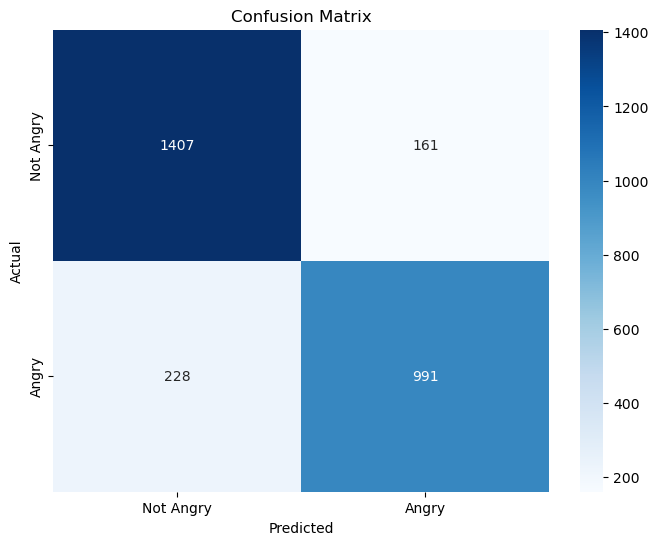

In [69]:
X = augmented_emotions_df[[f'MFCC_{i}' for i in range(20)]].values
y_binary = augmented_emotions_df['Binary_Emozioni'].values

# divido i dati in set di training e test
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# addestro il modello di regressione logistica
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# previsione sulle istanze di test
y_pred = model.predict(X_test)

# calcolo l'indice di accuratezza
accuracy = accuracy_score(y_test, y_pred)
print("Accuratezza del mio modello:", accuracy)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)

mean_popularity = y_test.mean()
null_model_y = [mean_popularity] * len(y_test)

print('\nModello nullo:')
print('MAE: %.3f' % metrics.mean_absolute_error(y_test, null_model_y))
print('MSE: %.3f' % metrics.mean_squared_error(y_test, null_model_y))
print('RMSE: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, null_model_y)))

# visualizzo il report di classificazione
print("\nReport di cassificazione:")
print(classification_report(y_test, y_pred))

# matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Angry', 'Angry'], yticklabels=['Not Angry', 'Angry'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

L'accuratezza del mio modello è abbastanza alta, di circa 0.86: il modello ha quindi classificato correttamente l'86% dei campioni nel set di test.

Il Mean Absolute Error (Errore Assoluto Medio) è di 0.140, indicando che, in media, le previsioni del modello si discostano di 0.140 dalla classe vera.

Il Mean Squared Error (Errore Quadratico Medio) è di 0.140. Essendo uguale al MAE, suggerisce che gli errori non sono particolarmente influenzati da outliers.

Le metriche per il modello nullo sono significativamente peggiori rispetto a quelle del modello addestrato, il che indica che il modello di Regressione Logistica è molto più efficace nel predire le classi rispetto a un modello che predice sempre la media delle classi.

Il modello ha un'alta precisione e richiamo per la classe 0 "not angry": possiamo concludere che identifica correttamente la maggior parte dei campioni "not angry" e ha pochi falsi positivi.

Anche se la precisione per la classe 1 è la stessa della classe 0, il richiamo è leggermente più basso, suggerendo che il modello ha una tendenza a perdere alcuni campioni "angry" (falsi negativi).

Dalla matrice di confusione vediamo che:

- 1407 campioni sono stati correttamente classificati come "not angry"

- 161 campioni sono stati erroneamente classificati come "angry"

- 990 campioni sono stati correttamente classificati come "angry"

- 229 campioni sono stati erroneamente classificati come "not angry"

Possiamo concludere che il modello di Regressione Logistica è abbastanza buono come metodo predittivo per il nostro scopo, ma grazie soprattutto all'integrazione di nuove istanze di tipo "angry" effettuata durante l'operazione di Data Augmentation: senza questa manipolazione la classe 0 "not angry" avrebbe preso il sopravvento, perciò un modello nullo che restituisce l'etichetta "not angry" il 100% delle volte avrebbe avuto una performance ben migliore di quella di un modello di Regressione Logistica.

Sarebbe interessante effettuare la Features Extraction combinando l'MFCC con altri metodi e vedere se in questo modo la precisione del nostro modello aumenta ulteriormente.